In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Activation, Bidirectional, LSTM, Attention, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from joblib import load
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Load the Preprocessed Data
X_train, X_test, y_train_one_hot, y_test_one_hot, class_weights_dict = load('preprocessed_data_parallel.joblib')

emotion_labels = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Step 2: Adjust BatchNormalization placement and replace Flatten with GlobalAveragePooling
input_layer = Input(shape=(X_train.shape[1], 1))

# First Convolutional Block
conv1 = Conv1D(64, kernel_size=5, padding="same", kernel_regularizer=l2(0.002))(input_layer)
conv1 = BatchNormalization()(conv1)  # BatchNorm before activation
conv1 = MaxPooling1D(pool_size=2)(conv1)
conv1 = Activation('relu')(conv1)

# Second Convolutional Block
conv2 = Conv1D(128, kernel_size=5, padding="same", activation="relu", kernel_regularizer=l2(0.002))(conv1)
conv2 = MaxPooling1D(pool_size=2)(conv2)
conv2 = BatchNormalization()(conv2)

# Add another Conv1D + MaxPooling block for deeper feature extraction
conv3 = Conv1D(256, kernel_size=3, padding="same", activation="relu", kernel_regularizer=l2(0.001))(conv2)
conv3 = MaxPooling1D(pool_size=2)(conv3)
conv3 = BatchNormalization()(conv3)

# Modify LSTM to stack more layers for sequential feature extraction
lstm_out = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))(conv3)
lstm_out2 = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)))(lstm_out)

attention = Attention()([lstm_out2, lstm_out2])
dropout_lstm = Dropout(0.3)(lstm_out2)
combined = Concatenate()([dropout_lstm, attention])

# Concatenate LSTM output with attention output
combined = Concatenate()([lstm_out, attention])

# Use Global Average Pooling instead of Flatten
gap = GlobalAveragePooling1D()(combined)
dense1 = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(gap)
dropout1 = Dropout(0.6)(dense1)
dense2 = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(dropout1)
dropout2 = Dropout(0.6)(dense2)

output_layer = Dense(len(emotion_labels), activation='softmax')(dropout2)
model = Model(inputs=input_layer, outputs=output_layer)

# Optimizer and Learning Rate
optimizer = Adam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Step 10: Set Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)
model_checkpoint = ModelCheckpoint("best_model_parallel.keras", monitor='val_accuracy', save_best_only=True)

# Step 11: Train the Model
history = model.fit(X_train, y_train_one_hot, epochs=100, batch_size=32, validation_data=(X_test, y_test_one_hot),
                    class_weight=class_weights_dict,  # Pass class weights here
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])



2024-11-15 16:15:22.903546: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-15 16:15:23.060496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731687323.144904   13241 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731687323.185728   13241 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 16:15:23.350109: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Epoch 1/100


I0000 00:00:1731687462.460274   38673 cuda_dnn.cc:529] Loaded cuDNN version 90300


216/216 ━━━━━━━━━━━━━━━━━━━━ 71s 99ms/step - accuracy: 0.1720 - loss: 3.8129 - val_accuracy: 0.1904 - val_loss: 3.6346 - learning_rate: 1.0000e-04
Epoch 2/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.2162 - loss: 3.5271 - val_accuracy: 0.2853 - val_loss: 3.3669 - learning_rate: 1.0000e-04
Epoch 3/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.2370 - loss: 3.3282 - val_accuracy: 0.3293 - val_loss: 3.1345 - learning_rate: 1.0000e-04
Epoch 4/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.2521 - loss: 3.1568 - val_accuracy: 0.3166 - val_loss: 2.9767 - learning_rate: 1.0000e-04
Epoch 5/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.2906 - loss: 3.0053 - val_accuracy: 0.3953 - val_loss: 2.7568 - learning_rate: 1.0000e-04
Epoch 6/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.3151 - loss: 2.8414 - val_accuracy: 0.3744 - val_loss: 2.6640 - learning_rate: 1.0000e-04
Epoch 7/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - a

NameError: name 'history_model1' is not defined

In [2]:
from joblib import dump
dump(history, 'history_model1.joblib')
# Step 12: Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
print(f"Test Accuracy: {test_accuracy:.4f}")


54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8392 - loss: 1.2659
Test Accuracy: 0.8368


In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Activation, Bidirectional, LSTM, Attention, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from joblib import load
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Load the Preprocessed Data
X_train, X_test, y_train_one_hot, y_test_one_hot, class_weights_dict = load('sequential_preprocessed_data.joblib')

emotion_labels = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Step 2: Adjust BatchNormalization placement and replace Flatten with GlobalAveragePooling
num_features = X_train.shape[2]  # Extract the number of features from the data

input_layer = Input(shape=(X_train.shape[1], num_features))  # Adjusted for sequential data

# First Convolutional Block
conv1 = Conv1D(64, kernel_size=5, padding="same", kernel_regularizer=l2(0.002))(input_layer)
conv1 = BatchNormalization()(conv1)  # BatchNorm before activation
conv1 = MaxPooling1D(pool_size=2)(conv1)
conv1 = Activation('relu')(conv1)

# Second Convolutional Block
conv2 = Conv1D(128, kernel_size=5, padding="same", activation="relu", kernel_regularizer=l2(0.002))(conv1)
conv2 = MaxPooling1D(pool_size=2)(conv2)
conv2 = BatchNormalization()(conv2)

# Add another Conv1D + MaxPooling block for deeper feature extraction
conv3 = Conv1D(256, kernel_size=3, padding="same", activation="relu", kernel_regularizer=l2(0.001))(conv2)
conv3 = MaxPooling1D(pool_size=2)(conv3)
conv3 = BatchNormalization()(conv3)

# Modify LSTM to stack more layers for sequential feature extraction
lstm_out = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))(conv3)
lstm_out2 = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)))(lstm_out)

attention = Attention()([lstm_out2, lstm_out2])
dropout_lstm = Dropout(0.3)(lstm_out2)
combined = Concatenate()([dropout_lstm, attention])

# Concatenate LSTM output with attention output
combined = Concatenate()([lstm_out, attention])

# Use Global Average Pooling instead of Flatten
gap = GlobalAveragePooling1D()(combined)
dense1 = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(gap)
dropout1 = Dropout(0.6)(dense1)
dense2 = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(dropout1)
dropout2 = Dropout(0.6)(dense2)

output_layer = Dense(len(emotion_labels), activation='softmax')(dropout2)
model = Model(inputs=input_layer, outputs=output_layer)

# Optimizer and Learning Rate
optimizer = Adam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Step 10: Set Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)
model_checkpoint = ModelCheckpoint("best_model_sequential.keras", monitor='val_accuracy', save_best_only=True)

# Step 11: Train the Model
history = model.fit(X_train, y_train_one_hot, epochs=100, batch_size=32, validation_data=(X_test, y_test_one_hot),
                    class_weight=class_weights_dict,  # Pass class weights here
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])
from joblib import dump
dump(history, 'history_model2.joblib')
# Step 12: Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
print(f"Test Accuracy: {test_accuracy:.4f}")






2024-11-15 17:06:07.207211: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-15 17:06:18.429743: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731690381.982084     486 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731690382.665938     486 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 17:06:31.065811: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Epoch 1/100


I0000 00:00:1731690562.377226     667 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/144 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - accuracy: 0.1797 - loss: 4.0216  

2024-11-15 17:09:53.400127: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.69GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


144/144 ━━━━━━━━━━━━━━━━━━━━ 61s 100ms/step - accuracy: 0.1505 - loss: 4.0349 - val_accuracy: 0.2109 - val_loss: 3.8617 - learning_rate: 1.0000e-04
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.1990 - loss: 3.8213 - val_accuracy: 0.2587 - val_loss: 3.6319 - learning_rate: 1.0000e-04
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.2642 - loss: 3.6323 - val_accuracy: 0.3168 - val_loss: 3.4167 - learning_rate: 1.0000e-04
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.2788 - loss: 3.4451 - val_accuracy: 0.3733 - val_loss: 3.2391 - learning_rate: 1.0000e-04
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.3293 - loss: 3.2491 - val_accuracy: 0.4167 - val_loss: 3.0530 - learning_rate: 1.0000e-04
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.3880 - loss: 3.0719 - val_accuracy: 0.4470 - val_loss: 2.8809 - learning_rate: 1.0000e-04
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - 

2024-11-20 09:24:52.544161: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-20 09:25:07.499526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732094713.677338    1050 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732094714.992570    1050 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 09:25:29.984123: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

36/36 ━━━━━━━━━━━━━━━━━━━━ 31s 37ms/step - accuracy: 0.8035 - loss: 1.8466
Hybrid Sequential Model - Test Loss: 1.8851, Test Accuracy: 0.7986
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8413 - loss: 1.2900
Hybrid Parallel Model - Test Loss: 1.2822, Test Accuracy: 0.8455


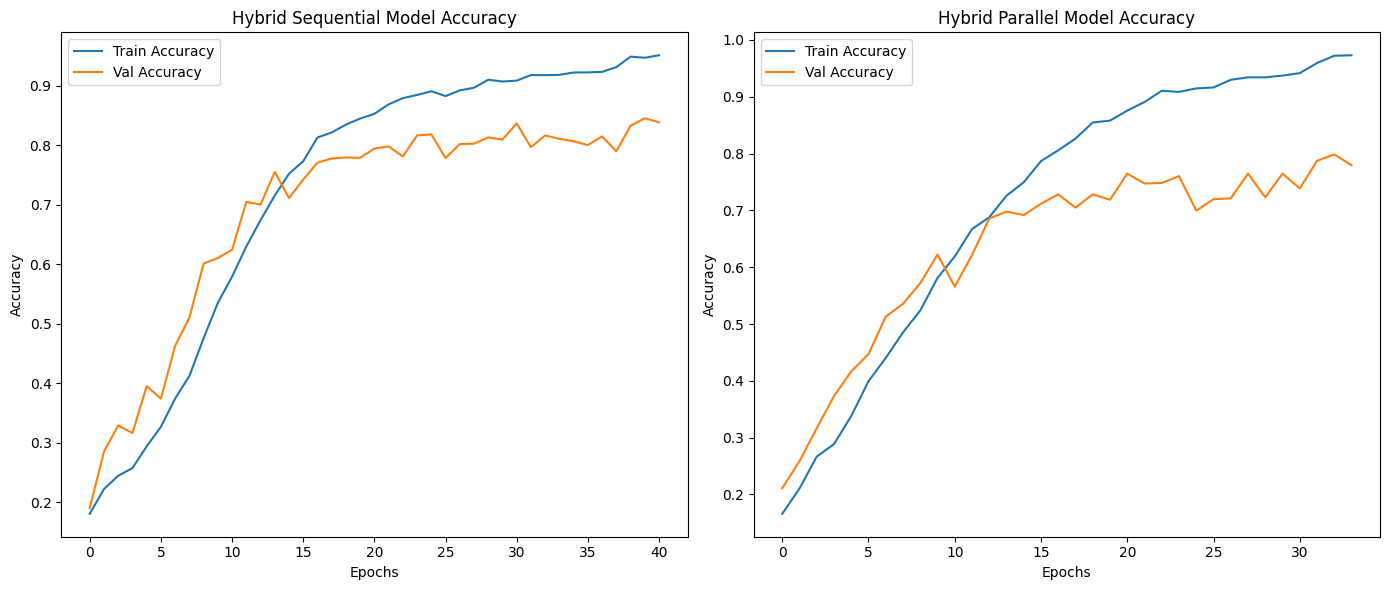

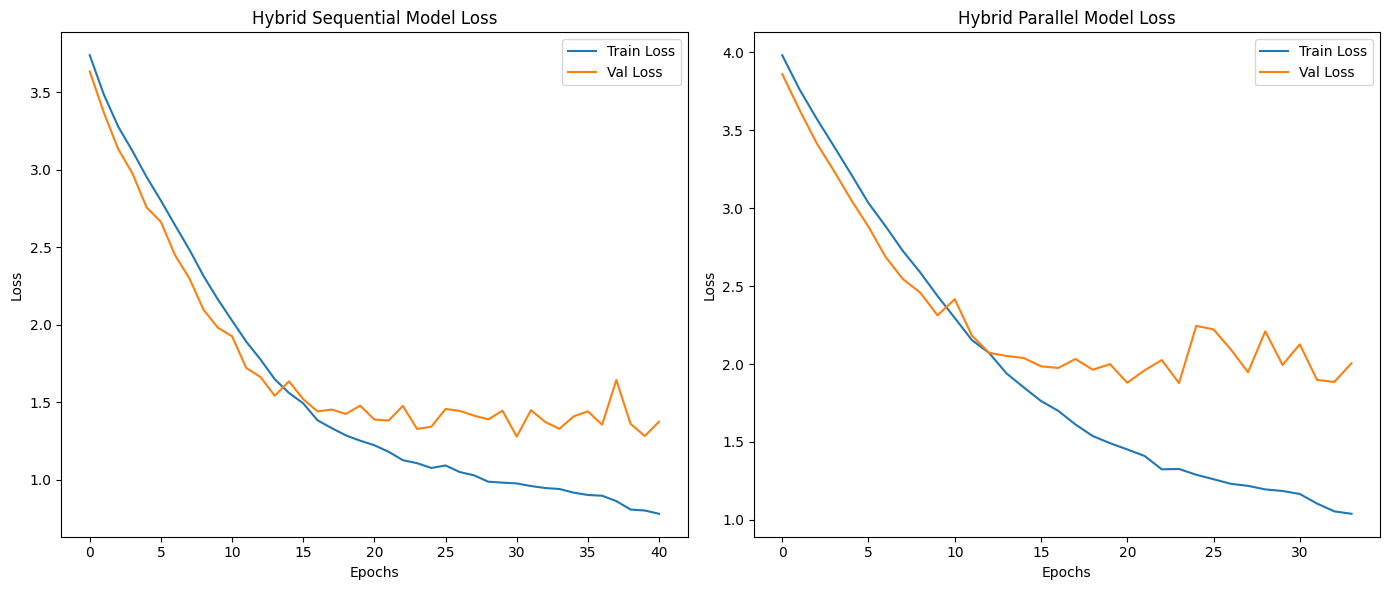

Hybrid Sequential Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 180)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 180, 64)   │     57,664 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 180, 64)   │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 90, 64)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 90, 64)    │          0 │ max_pooling1d[0]… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 90, 128)   │     41,088 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 45, 128)   │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 128)   │        512 │ max_pooling1d_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 45, 256)   │     98,560 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 22, 256)   │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 256)   │      1,024 │ max_pooling1d_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 22, 256)   │    394,240 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 22, 128)   │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 22, 128)   │          0 │ bidirectional_1[… │
│ (Attention)         │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 22, 384)   │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 384)       │          0 │ concatenate_1[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     49,280 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,445,466 (9.33 MB)

 Trainable params: 814,856 (3.11 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 1,629,714 (6.22 MB)

Hybrid Parallel Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 180, 64)   │        384 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 180, 64)   │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 90, 64)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 90, 64)    │          0 │ max_pooling1d[0]… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 90, 128)   │     41,088 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 45, 128)   │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 128)   │        512 │ max_pooling1d_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 45, 256)   │     98,560 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 22, 256)   │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 256)   │      1,024 │ max_pooling1d_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 22, 256)   │    394,240 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 22, 128)   │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 22, 128)   │          0 │ bidirectional_1[… │
│ (Attention)         │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 22, 384)   │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 384)       │          0 │ concatenate_1[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     49,280 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,273,626 (8.67 MB)

 Trainable params: 757,576 (2.89 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 1,515,154 (5.78 MB)

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
Hybrid Sequential Model Classification Report:
              precision    recall  f1-score   support

     neutral       0.90      0.78      0.84       139
        calm       0.85      0.86      0.86       168
       happy       0.81      0.83      0.82       162
         sad       0.79      0.72      0.75       138
       angry       0.80      0.76      0.78       157
     fearful       0.72      0.69      0.71        78
     disgust       0.68      0.81      0.74       163
   surprised       0.85      0.86      0.85       147

    accuracy                           0.80      1152
   macro avg       0.80      0.79      0.79      1152
weighted avg       0.80      0.80      0.80      1152

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s -89010us/step
Hybrid Parallel Model Classification Report:
              precision    recall  f1-score   support

     neutral       0.84      0.92      0.88       225
        calm       0.91      0.81      0.86       220
       hap

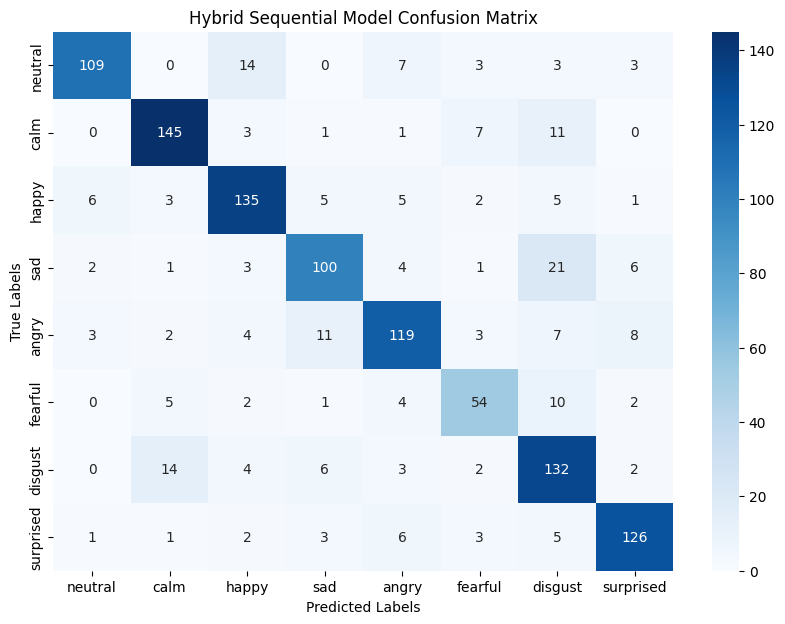

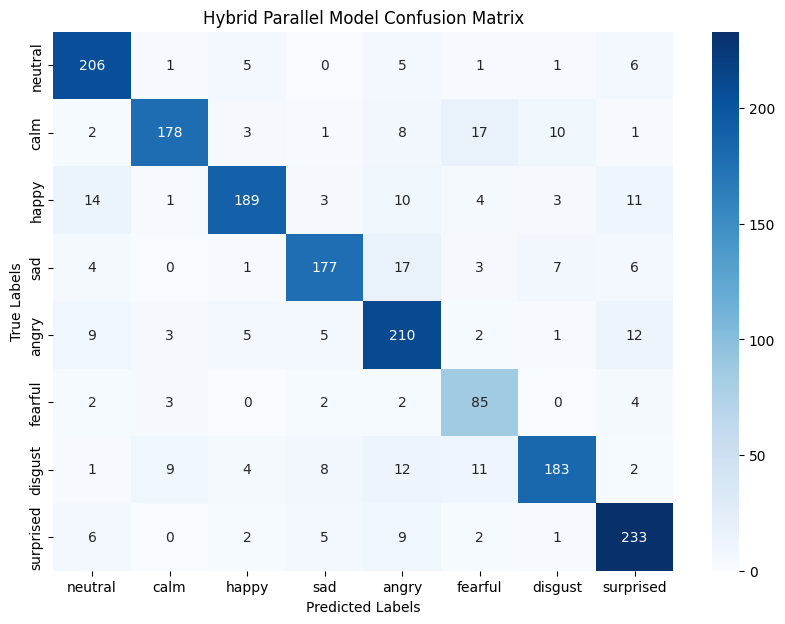

Hybrid Sequential Model Parameters: 815752
Hybrid Parallel Model Parameters: 758472


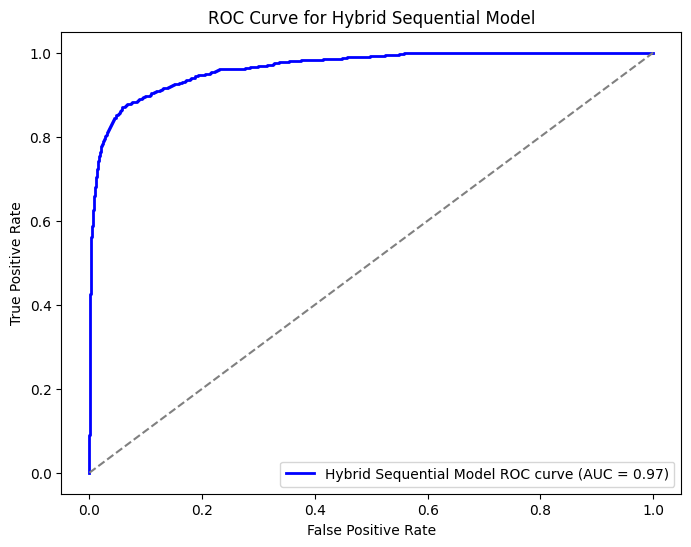

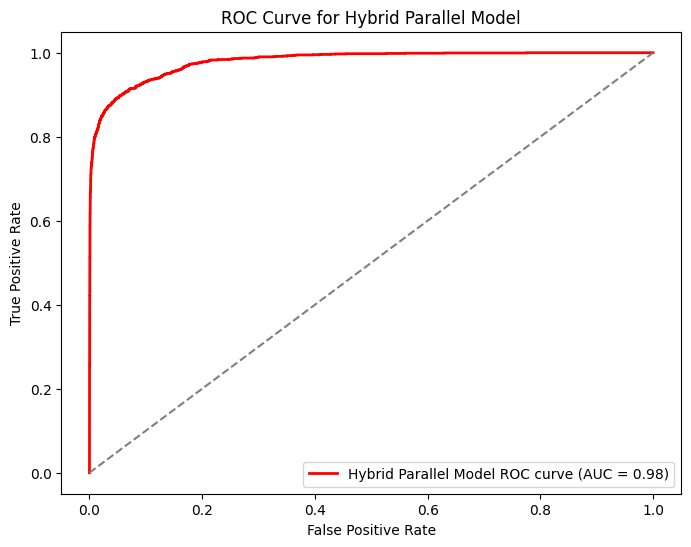

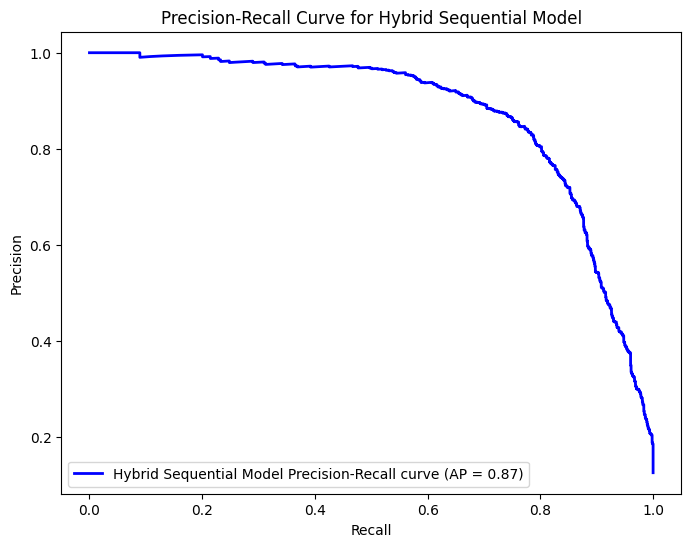

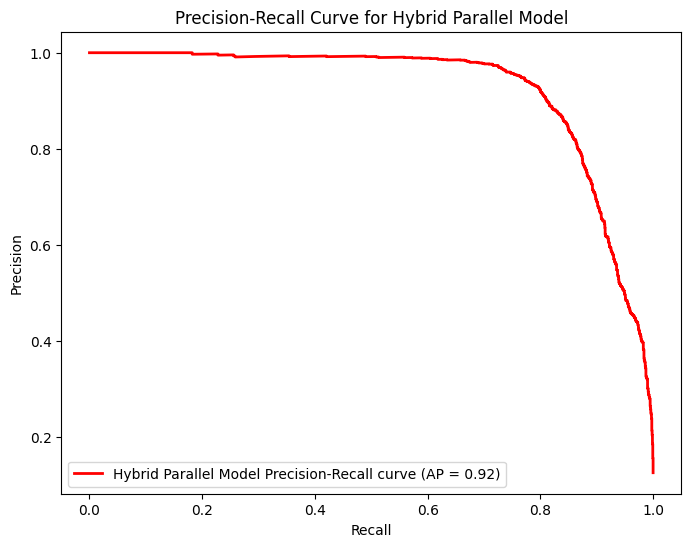

In [1]:
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns

# Step 1: Load the Preprocessed Data
X_train, X_test, y_train_one_hot, y_test_one_hot, class_weights_dict = joblib.load('sequential_preprocessed_data.joblib')
X_train_par, X_test_par, y_train_par, y_test_par, class_weights_dict_par = joblib.load('preprocessed_data_parallel.joblib')

emotion_labels = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

# Load saved history for Hybrid models
history_sequential = joblib.load('history_model1.joblib')
history_parallel = joblib.load('history_model2.joblib')

# Load the saved Hybrid models
model_sequential = load_model('best_model_sequential.keras')
model_parallel = load_model('best_model_parallel.keras')

# Evaluate Hybrid Sequential Model on Test Data
test_loss_seq, test_accuracy_seq = model_sequential.evaluate(X_test, y_test_one_hot)
print(f"Hybrid Sequential Model - Test Loss: {test_loss_seq:.4f}, Test Accuracy: {test_accuracy_seq:.4f}")

# Evaluate Hybrid Parallel Model on Test Data
test_loss_par, test_accuracy_par = model_parallel.evaluate(X_test_par, y_test_par)
print(f"Hybrid Parallel Model - Test Loss: {test_loss_par:.4f}, Test Accuracy: {test_accuracy_par:.4f}")     

# Plot Training & Validation Accuracy for both models
plt.figure(figsize=(14, 6))

# Hybrid Sequential Model Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_sequential.history['accuracy'], label='Train Accuracy')
plt.plot(history_sequential.history['val_accuracy'], label='Val Accuracy')
plt.title('Hybrid Sequential Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Hybrid Parallel Model Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_parallel.history['accuracy'], label='Train Accuracy')
plt.plot(history_parallel.history['val_accuracy'], label='Val Accuracy')
plt.title('Hybrid Parallel Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Training & Validation Loss for both models
plt.figure(figsize=(14, 6))
# Hybrid Sequential Model Loss
plt.subplot(1, 2, 1)
plt.plot(history_sequential.history['loss'], label='Train Loss')
plt.plot(history_sequential.history['val_loss'], label='Val Loss')
plt.title('Hybrid Sequential Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Hybrid Parallel Model Loss
plt.subplot(1, 2, 2)
plt.plot(history_parallel.history['loss'], label='Train Loss')
plt.plot(history_parallel.history['val_loss'], label='Val Loss')
plt.title('Hybrid Parallel Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Model Summary for Hybrid Sequential Model
print("Hybrid Sequential Model Summary:")
model_sequential.summary()

# Model Summary for Hybrid Parallel Model
print("Hybrid Parallel Model Summary:")
model_parallel.summary()

# Sequential Model Prediction and Metrics
y_pred_seq = model_sequential.predict(X_test)
y_pred_seq_classes = y_pred_seq.argmax(axis=-1)  # Convert softmax output to class labels
y_true_seq = y_test_one_hot.argmax(axis=-1)  # Convert one-hot labels to class labels
print("Hybrid Sequential Model Classification Report:")
print(classification_report(y_true_seq, y_pred_seq_classes, target_names=emotion_labels.values()))

# Parallel Model Prediction and Metrics
y_pred_par = model_parallel.predict(X_test_par)
y_pred_par_classes = y_pred_par.argmax(axis=-1)  # Convert softmax output to class labels
y_true_par = y_test_par.argmax(axis=-1)  # Convert one-hot labels to class labels
print("Hybrid Parallel Model Classification Report:")
print(classification_report(y_true_par, y_pred_par_classes, target_names=emotion_labels.values()))

# Confusion Matrix for Hybrid Sequential Model
conf_mat_seq = confusion_matrix(y_true_seq, y_pred_seq_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat_seq, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
plt.title('Hybrid Sequential Model Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Confusion Matrix for Hybrid Parallel Model
conf_mat_par = confusion_matrix(y_true_par, y_pred_par_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat_par, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
plt.title('Hybrid Parallel Model Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Calculate the number of parameters for both models
params_seq = model_sequential.count_params()
params_par = model_parallel.count_params()

print(f"Hybrid Sequential Model Parameters: {params_seq}")
print(f"Hybrid Parallel Model Parameters: {params_par}")   

# ROC Curve for Hybrid Sequential Model
lb = LabelBinarizer()
y_true_bin_seq = lb.fit_transform(y_test_one_hot)
fpr_seq, tpr_seq, _ = roc_curve(y_true_bin_seq.ravel(), y_pred_seq.ravel())
roc_auc_seq = auc(fpr_seq, tpr_seq)

plt.figure(figsize=(8, 6))
plt.plot(fpr_seq, tpr_seq, color='blue', lw=2, label='Hybrid Sequential Model ROC curve (AUC = {:.2f})'.format(roc_auc_seq))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Hybrid Sequential Model')
plt.legend(loc='lower right')
plt.show()

# ROC Curve for Hybrid Parallel Model
y_true_bin_par = lb.fit_transform(y_test_par)
fpr_par, tpr_par, _ = roc_curve(y_true_bin_par.ravel(), y_pred_par.ravel())
roc_auc_par = auc(fpr_par, tpr_par)

plt.figure(figsize=(8, 6))
plt.plot(fpr_par, tpr_par, color='red', lw=2, label='Hybrid Parallel Model ROC curve (AUC = {:.2f})'.format(roc_auc_par))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Hybrid Parallel Model')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve for Hybrid Sequential Model
precision_seq, recall_seq, _ = precision_recall_curve(y_true_bin_seq.ravel(), y_pred_seq.ravel())
average_precision_seq = average_precision_score(y_true_bin_seq, y_pred_seq, average='macro')

plt.figure(figsize=(8, 6))
plt.plot(recall_seq, precision_seq, color='blue', lw=2, label='Hybrid Sequential Model Precision-Recall curve (AP = {:.2f})'.format(average_precision_seq))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Hybrid Sequential Model')
plt.legend(loc='lower left')
plt.show()

# Precision-Recall Curve for Hybrid Parallel Model
precision_par, recall_par, _ = precision_recall_curve(y_true_bin_par.ravel(), y_pred_par.ravel())
average_precision_par = average_precision_score(y_true_bin_par, y_pred_par, average='macro')

plt.figure(figsize=(8, 6))
plt.plot(recall_par, precision_par, color='red', lw=2, label='Hybrid Parallel Model Precision-Recall curve (AP = {:.2f})'.format(average_precision_par))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Hybrid Parallel Model')
plt.legend(loc='lower left')
plt.show()


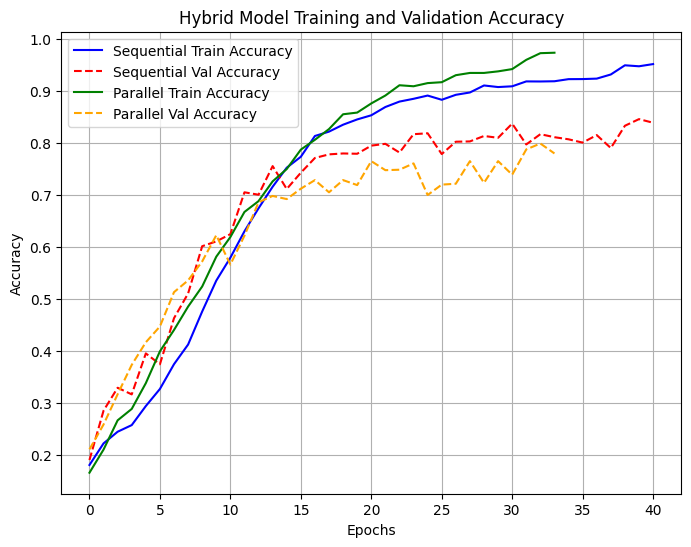

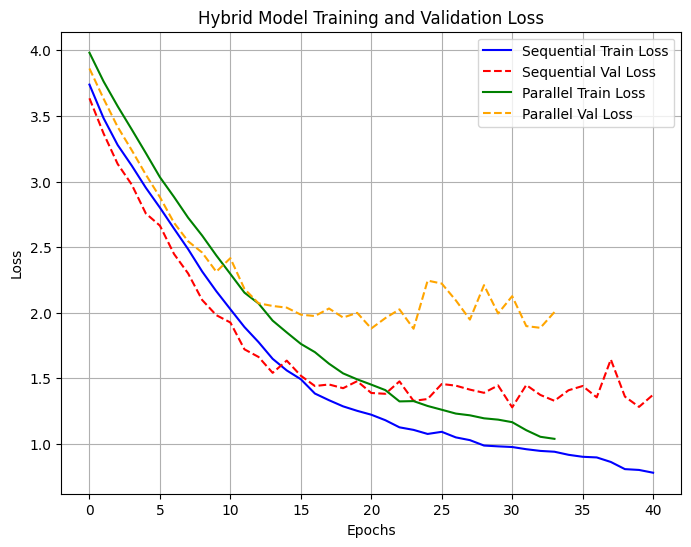

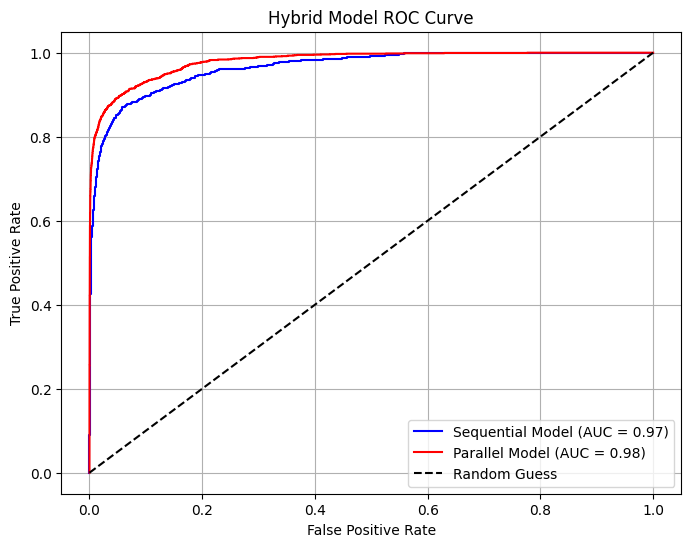

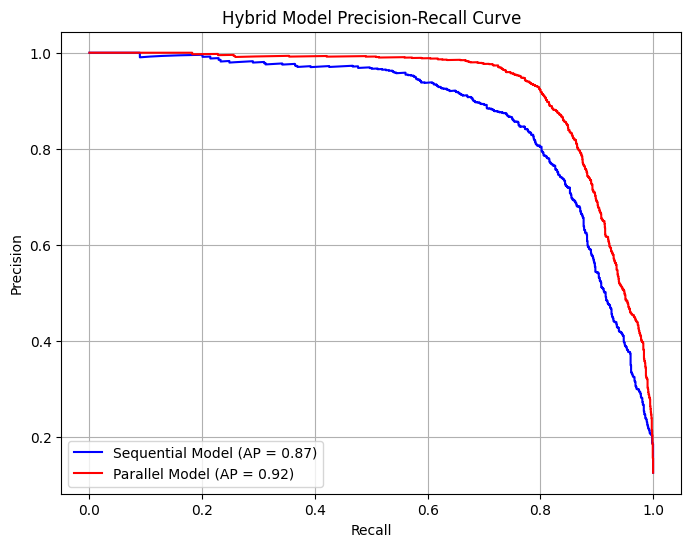

In [5]:
plt.figure(figsize=(8, 6))
plt.plot(history_sequential.history['accuracy'], label='Sequential Train Accuracy', color='blue', linestyle='-')
plt.plot(history_sequential.history['val_accuracy'], label='Sequential Val Accuracy', color='red', linestyle='--')
plt.plot(history_parallel.history['accuracy'], label='Parallel Train Accuracy', color='green', linestyle='-')
plt.plot(history_parallel.history['val_accuracy'], label='Parallel Val Accuracy', color='orange', linestyle='--')
plt.title('Hybrid Model Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history_sequential.history['loss'], label='Sequential Train Loss', color='blue', linestyle='-')
plt.plot(history_sequential.history['val_loss'], label='Sequential Val Loss', color='red', linestyle='--')
plt.plot(history_parallel.history['loss'], label='Parallel Train Loss', color='green', linestyle='-')
plt.plot(history_parallel.history['val_loss'], label='Parallel Val Loss', color='orange', linestyle='--')
plt.title('Hybrid Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(fpr_seq, tpr_seq, label=f'Sequential Model (AUC = {roc_auc_seq:.2f})', color='blue')
plt.plot(fpr_par, tpr_par, label=f'Parallel Model (AUC = {roc_auc_par:.2f})', color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('Hybrid Model ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(recall_seq, precision_seq, label=f'Sequential Model (AP = {average_precision_seq:.2f})', color='blue')
plt.plot(recall_par, precision_par, label=f'Parallel Model (AP = {average_precision_par:.2f})', color='red')
plt.title('Hybrid Model Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
